<font size="4" face="verdana" color="red"> Brainery Byte
<hr></font>
<font size="6" face="verdana" color="blue"> OpenSees <b>MODEL-VISUALIZATION</b> Basics<br>
    <br>
<br>
</font><p>

<font size="4" face="verdana" color="black">
 R210719 <br>
 Silvia Mazzoni, 2021 <br>
      silviamazzoni@yahoo.com <br>

<br>
The objective of this workbook is to demonstrate the fundamentals of taking advantage of Python to visualize your model as you develop it.<br>
    <p>
    
<font size="4" face="verdana" color="black">
    <b>Visualize:</b>
<ol type="1">
  <li>Material Stress-Strain Behavior</li>
  <li>Fiber Section</li>
  <li>Section Moment-Curvature Response</li>
  <li>Fiber-Section Strains</li>
  <li>Section P-M Interaction Response</li>
  <li>Model</li>
  <li>Model Standard Eigenvectors</li>
    <br>

</ol>
</font>
<font size="3" face="verdana" color="black">
   <br>
    <b>NOTES:</b>
    <ol>
        <li> The following videos on my YouTube Channel provide detailed explanations of this notebook.</li>
        <ol type="1">
            <li> <a href = "https://youtu.be/8AFhbeVl3qY"> Part 1: Materials and Sections</a></li>
            <li> <a href = "https://youtu.be/CTqG3GbB0i0"> Part 2: The 3D Model</a></li>
        </ol>
        <li> You can learn more about Standard Eigenvectors in the <a href = "https://portwooddigital.com/2020/11/13/ordinary-eigenvalues/"> Portwood Digital Blog </a> 
        <li> This script takes advantage of dictionaries as a data structure to store model info. Using this apparent extra step allows you to store the information of your model in case you need to use it in post-processing. For example, it allows you to draw the fiber sections</li>
        <li>Yes this WebApp uses function eSEESminiPy package to make the tool easier to use</li>
        <li>Make sure you visit my <a href="https://www.silviasbrainery.com/brainerybytes"> Brainery Bytes </a> page for more!</li>
    </ol>
</font>
    
<BR>
    
When you are done, you can print the notebook. You can also download the notebook to your local computer.

Because we are working in Binder, and Binder sessions are meant to be ephemeral, it is not possible for you to save any changes you make to your Jupyter Notebook. If you do make changes or notes, you will need to download the notebook to your own computer by clicking File > Download as > Notebook (.ipynb). The only way you will be able to run these is if you have the appropriate software to run Jupyter Notebooks in Python and pip install OpenSeesPy and eSEESminiPy in your Python configuration. You may view my videos on how to install Anaconda, Jupyter Notebooks and OpenSeesPy (https://www.youtube.com/c/silviasbrainery).
    
This Code has been developed by Silvia Mazzoni. Please acknowledge this in your scripts, when applicable

In [1]:
# SET UP PYTHON
import openseespy.opensees as ops
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import eSEESminiPy

In [2]:
# Turn on interaction for plots so you can rotate 3D plots
# you can put this here, but then the notebook will complain that you have too many figures open and 
# that consumes a lot of memory. so I have placed this comment before we define the 3D models.
# you can turn this on here so you can look at the numbers in the early plots as well, if you'd like
#%matplotlib notebook

In [3]:
%%javascript
// expand output box so graphs are viewed in notebook properly
IPython.OutputArea.auto_scroll_threshold = 10000;

<IPython.core.display.Javascript object>

In [4]:
# define UNITS ----------------------------------------------------------------------------
# unit conversion factors

inch  = 1.  # define basic units -- output units
kip  = 1. # define basic units -- output units
sec  = 1. # define basic units -- output units

LunitTXT  = 'inch' # define basic-unit text for output
FunitTXT  = 'kip' # define basic-unit text for output
TunitTXT  = 'sec' # define basic-unit text for output

ft  = 12.*inch # define engineering units
ksi  = kip/math.pow(inch,2)
psi  = ksi/1000.
lbf  = psi*inch*inch # pounds force
pcf  = lbf/math.pow(ft,3) # pounds per cubic foot
psf  = lbf/math.pow(ft,3) # pounds per square foot
inch2  = inch*inch # inch^2
inch4  = inch*inch*inch*inch # inch^4
cm  = inch/2.54 # centimeter, needed for displacement input in MultipleSupport excitation
PI  = 2*math.asin(1.0) # define constants
g  = 32.2*ft/math.pow(sec,2) # gravitational acceleration
Ubig  = 1.e10 # a really large number
Usmall  = 1/Ubig # a really small number
inchInv = 1/inch;


In [5]:
# Initialize Arrays and variables
matTag = 0
secTag = 0
SectionMaterialTagMap = {}
SectionTagMap = {}
allSectionData = {}
MatStressStrainData = {}
MomCurvData = {}

plt.close('all')

In [6]:
# UTILITIES
# Define some local handy procs
def defineStrainHistory(peaksArray,nCycles,nSteps,scaleFactor = 1):
    import numpy as np
    strain = []
    thisPeak0 = 0
    for thisPeak in peaksArray:
        if nCycles == 0:
            strain = np.append(strain,np.linspace(thisPeak0,thisPeak*scaleFactor,nSteps))
            thisPeak0 = thisPeak*scaleFactor
        else:
            for i in range(nCycles):
                strain = np.append(strain,np.linspace(0,thisPeak*scaleFactor,nSteps))
                strain = np.append(strain,np.linspace(thisPeak*scaleFactor,-thisPeak*scaleFactor,2*nSteps))
                strain = np.append(strain,np.linspace(-thisPeak*scaleFactor,0,nSteps))
    return list(strain)

def formatAx(axModel,Title,xLabel,yLabel,titleFontSize = 12, otherFontSize = 12):
    axModel.grid(True,color='grey')
    handles, labels = axModel.get_legend_handles_labels()
    if len(handles)>0:
        axModel.legend(fontsize=otherFontSize)
    axModel.set_title(Title, fontsize=titleFontSize)
    axModel.set_xlabel(xLabel, fontsize=otherFontSize)
    axModel.set_ylabel(yLabel, fontsize=otherFontSize)            
    axModel.tick_params('x', labelsize=otherFontSize, rotation=0)
    axModel.tick_params('y', labelsize=otherFontSize, rotation=0)
    
def set_aspect_equal_3d(ax):
    #"""Fix equal aspect bug for 3D plots."""
    #https://stackoverflow.com/questions/13685386/matplotlib-equal-unit-length-with-equal-aspect-ratio-z-axis-is-not-equal-to
    import matplotlib.pyplot as plt

    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()

    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)

    plot_radius = max([abs(lim - mean_)
                       for lims, mean_ in ((xlim, xmean),
                                           (ylim, ymean),
                                           (zlim, zmean))
                       for lim in lims])

    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])    

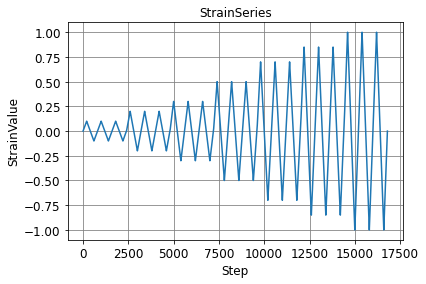

In [7]:
# Define Normalized Loading Cycles for Material and Section Testing.

# These cycles are normalized to have a maximum value of 1.0
# You can later change the amplitude factor depending on the application
peaksArray = [0.1,0.2,0.3,0.5,0.7,0.85,1.0]
nCycles = 3
nSteps = 200
StrainSeries = defineStrainHistory(peaksArray,nCycles,nSteps)
thisFig, thisAx = plt.subplots()
thisAx.plot(StrainSeries)
formatAx(thisAx,'StrainSeries','Step','StrainValue')
#thisAx.set_xlabel('Step')
#thisAx.set_ylabel('StrainValue')
#thisAx.set_title('StrainSeries')
#plt.grid()

In [8]:
# Start-up OpenSees
ops.wipe()     #  clear memory of all past model definitions

ops.model('BasicBuilder','-ndm',3,'-ndf',6)     #  Define the model builder, ndm= dimension, ndf= dofs
Dim = '3D'

In [9]:
################################################################################################
### STEEL W SECTION
MainSectionLabel = 'W14X193'
################################################################################################

thisSectionType = '_FiberOnly'
thisSectionLabel = MainSectionLabel + thisSectionType

# initialize Section Data
thisMaterialTagMap = {}

# DEFINE MATERIAL
# -----------------------------------
# Define Steel Material
Fy=50*ksi
YoungsModulus = 2.900E+04*ksi
Bsh = 0.01
nu  = 0.3
ShearModulus  = YoungsModulus/2./(1+nu) # Torsional stiffness Modulus

# Backbone points for Hysteretic Material
f1 = Fy
eps1 = Fy/YoungsModulus
eps2 = 20*eps1
f2 = f1+Bsh*(eps2-eps1)*(YoungsModulus)
f3 = 0.9*f2
eps3 = 50*eps1
PositiveEnvelopeData = [f1,eps1,f2,eps2,f3,eps3]
NegativeEnvelopeData = [-f1,-eps1,-f2,-eps2,-f3,-eps3]

# hyteretic-material properties
[pinchX,pinchY] = [1,1]
[damage1,damage2] = [0.0,0.0]
beta = 0.5
hystereticData = [pinchX,pinchY,damage1,damage2,beta]
# define a copy of the material for testing:
# you have to do this first as the testUniaxialMaterial messes with things
matTag += 1
thisMaterialTagMap['SteelTest'] = matTag
ops.uniaxialMaterial('Hysteretic',matTag,*PositiveEnvelopeData,*NegativeEnvelopeData,*hystereticData)
matTag += 1
thisMaterialTagMap['Steel'] = matTag
ops.uniaxialMaterial('Hysteretic',matTag,*PositiveEnvelopeData,*NegativeEnvelopeData,*hystereticData)




SectionMaterialTagMap[thisSectionLabel] = thisMaterialTagMap



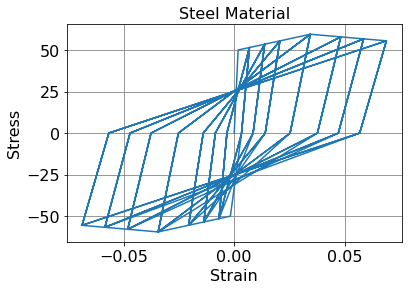

In [10]:
# Visualize Material Behavior
visualizeMaterialSwitch = True
# to be able to run OpenSees for the building frame, you have to turn this off, 
#   as the testUniaxialMaterial seems to affect the model builder
if visualizeMaterialSwitch:
    ampFactor = 2*eps2 
    ops.testUniaxialMaterial(thisMaterialTagMap['SteelTest'])
    strain = []
    stress = []
    for eps in StrainSeries:
        ops.setStrain(eps*ampFactor)
        strain.append(eps*ampFactor)
        stress.append(ops.getStress())


    thisFig, thisAx = plt.subplots()
    thisLine, = thisAx.plot(strain,stress)
    formatAx(thisAx,'Steel Material','Strain','Stress',16,16)
    #thisLine, = thisAx.plot(StrainSeries,stress)
    #thisAx.set_xlabel('Strain')
    #thisAx.set_ylabel('Stress')
    #thisAx.set_title('Steel')
    #plt.grid()

In [11]:
# Section Geometry
# look up properties for W section
thisSectionData = {'SectionLabel': 'W14X193',
 'A': '56.8*inch2',
 'D': '15.5*inch',
 'Bf': '15.7*inch',
 'Tf': '1.44*inch',
 'Tw': '0.89*inch',
 'Zpy': '179.9718755*inch3',
 'Zpz': '353.304809*inch3',
 'Ixx': '34.9*inch4',
 'Iyy': '931*inch4',
 'Izz': '2400*inch4'}

# FIBER SECTION properties
# assign a section Tag for OpenSees and save it in the data map
secTag += 1
SectionTagMap[thisSectionLabel] = secTag
thisSectionData['SectionTag'] = secTag

d = eval(thisSectionData['D'])
bf = eval(thisSectionData['Bf'])
tf = eval(thisSectionData['Tf'])
tw = eval(thisSectionData['Tw'])
J = eval(thisSectionData['Ixx'])
dw  = d-2 * tf
GJ = ShearModulus*J
thisSectionData['GJ'] = GJ

# maximum compression capacity of section
thisSectionData['PmaxC'] = -0.99*eval(thisSectionData['A'])*Fy
thisSectionData['PmaxT'] = 0.99*eval(thisSectionData['A'])*Fy


# define fiber section data
FiberSectionCommandData = {}
FiberSectionCommandData['sectionCall'] = ['section','Fiber',secTag,'-GJ',GJ]
[nfdw,nftw,nfbf,nftf] = [8,2,16,2]
# key coordinates in W section -- y is vertical-up, z is horizontal-left
[y1,y2,y3,y4] = [-d/2,-dw/2,dw/2,d/2]
[z1,z2,z3,z4] = [-bf/2,-tw/2,tw/2,bf/2]
matID = thisMaterialTagMap['Steel']
# define properties of patches following opensees input format
FiberSectionCommandData['BottomFlange'] = ['patch','quad',matID,nfbf,nftf,y1,z4,y1,z1,y2,z1,y2,z4]
FiberSectionCommandData['Web'] = ['patch','quad',matID,nftw,nfdw,y2,z3,y2,z2,y3,z2,y3,z3]
FiberSectionCommandData['TopFlange'] = ['patch','quad',matID,nfbf,nftf,y3,z4,y3,z1,y4,z1,y4,z4]

# Add recorder fibers (zero area) and define strain limit states
strainLimits = {}
strainLimits['Yield'] = [-1.1*eps1,1.1*eps1]
strainLimits['LS'] = [-2*eps1,2*eps1]
strainLimits['CP'] = [-4*eps1,4*eps1]
FiberSectionCommandData['BottomLeft'] = ['fiber',y1,z4,0,matID,strainLimits]
FiberSectionCommandData['BottomRight'] = ['fiber',y1,z1,0,matID,strainLimits]
FiberSectionCommandData['TopRight'] = ['fiber',y4,z1,0,matID,strainLimits]
FiberSectionCommandData['TopLeft'] = ['fiber',y4,z4,0,matID,strainLimits]
FiberSectionCommandData['Origin'] = ['fiber',0,0,0,matID,strainLimits]


# buildSection:
ops.section(*FiberSectionCommandData['sectionCall'][1:])
for thisFiberLabel,thisFiberCommandData in FiberSectionCommandData.items():
    fiberType = thisFiberCommandData[0]
    if fiberType == 'patch':
        ops.patch(*thisFiberCommandData[1:12+1])
    elif fiberType == 'layer':
        if thisFiberCommandData[3]>0:
            ops.layer(*thisFiberCommandData[1:8+1])
    elif fiberType == 'fiber':
        ops.fiber(*thisFiberCommandData[1:4+1])


thisSectionData['FiberSectionCommandData'] = FiberSectionCommandData
allSectionData[thisSectionLabel] = thisSectionData


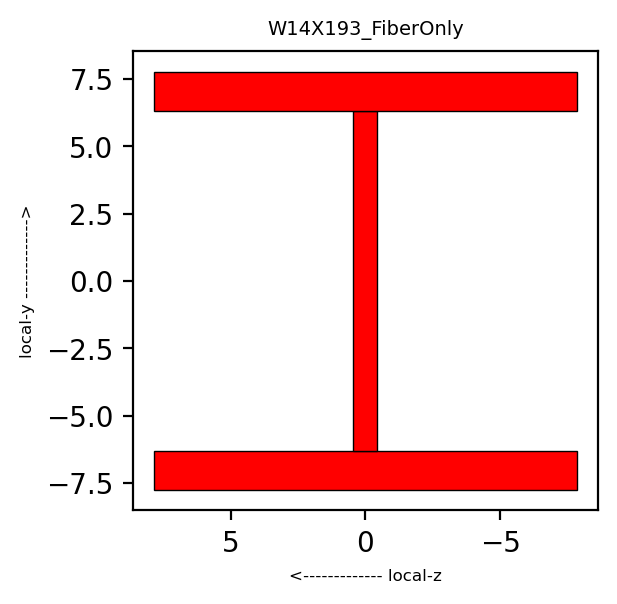

In [12]:
thisColorList = ['b', 'g', 'r', 'orange', 'y', 'c', 'm', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan','aliceblue']
    
figModel = plt.figure(thisSectionLabel,figsize=(3,4), dpi=200, facecolor='w')
axModel = figModel.add_subplot(1,1,1)
for thisFiberLabel,thisFiberCommandData in FiberSectionCommandData.items():
    fiberType = thisFiberCommandData[0]
    if fiberType == 'patch':
        patchType = thisFiberCommandData[1]
        matTag = thisFiberCommandData[2]
        thisColor = thisColorList[matTag]

        numSubdivIJ = thisFiberCommandData[3]
        numSubdivJK = thisFiberCommandData[4]
        yCoord = []
        zCoord = []
        for i in range(5, 12, 2):
            yCoord.append(thisFiberCommandData[i])
            zCoord.append(thisFiberCommandData[i+1])
        axModel.fill(zCoord,yCoord,thisColor, edgecolor='black', linewidth=0.5, zorder=5)

    
axModel.set_xlabel('<------------- local-z', fontsize=6)
axModel.set_ylabel('local-y ------------->', fontsize=6)
axModel.set_title(thisSectionLabel, fontsize=7)
axModel.set_aspect('equal', adjustable='box')

xlims = axModel.get_xlim()
axModel.set_xlim(xlims[1],xlims[0]) # reverse the x axis

plt.show()

In [13]:
## RUN Moment-Curvature Analysis
testSectionLabel = MainSectionLabel + thisSectionType
MomCurvData[testSectionLabel] = {}

# The InputSection is a single argument to the Moment-Curvature Analysis
# If you want strain-recorder data, include the FiberSectionDommandData into a list:
FiberSectionCommandData = allSectionData[testSectionLabel]['FiberSectionCommandData']
InputSection = [SectionTagMap[testSectionLabel],FiberSectionCommandData]

### MOMENT-CURVATURE ANALYSIS
axialLoad = 180
ampFactor = 0.01
thisLimitState = '' # no limit state as we are doing a cyclic analysis
for BendingDirection in ['z','y']:
    MomCurvData[testSectionLabel][BendingDirection] = eSEESminiPy.runMomentCurvature(InputSection,axialLoad,StrainSeries,5,Dim+BendingDirection,ampFactor,thisLimitState)
    


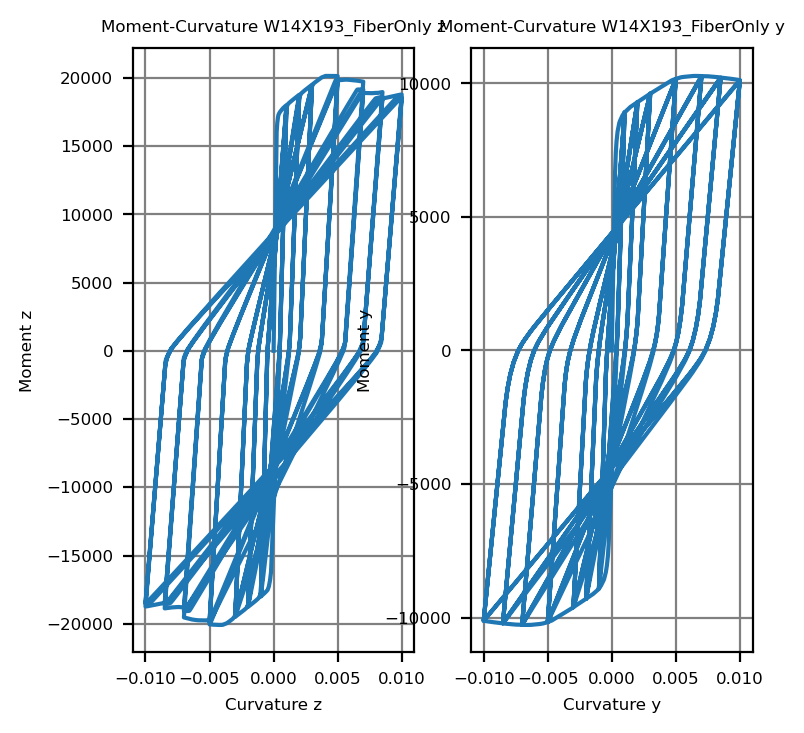

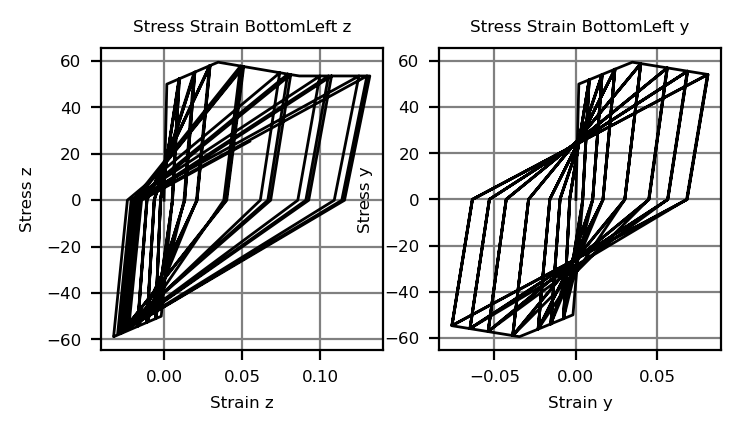

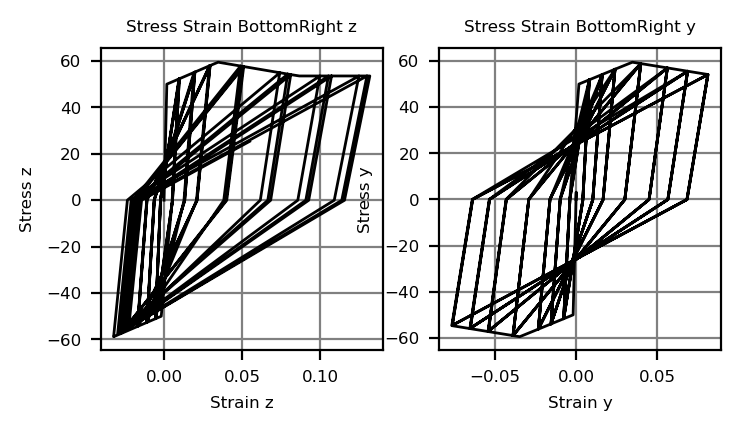

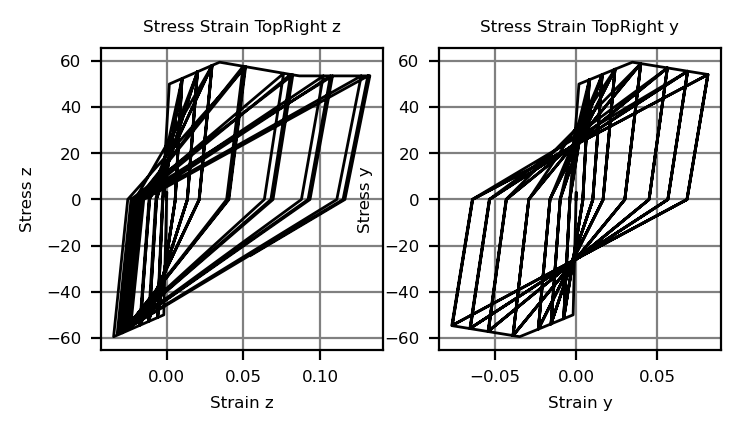

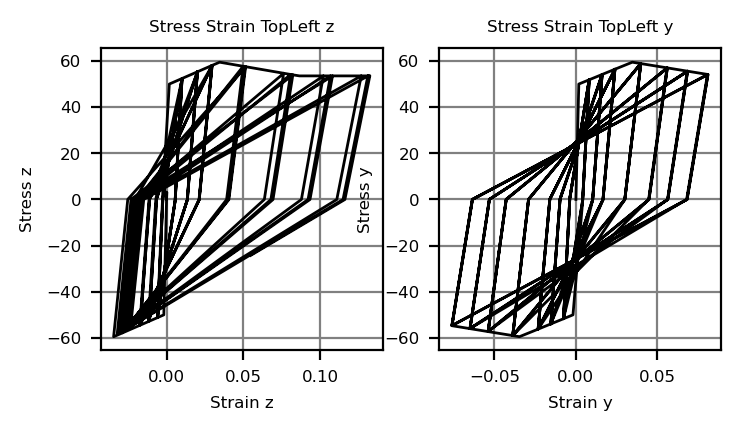

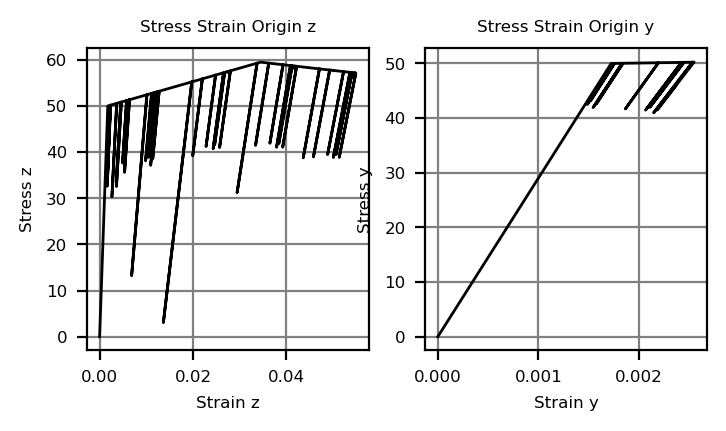

In [14]:
### Plot Moment-Curvature Responses
thisFig = {}
axModel = {}
thisFigMomCurv = plt.figure('Moment Curvature ' + testSectionLabel,figsize=(4,4), dpi=200, facecolor='w', edgecolor='k' )
iAx = 0
for BendingDirection in MomCurvData[testSectionLabel].keys():
    iAx += 1
    axMomCurv = thisFigMomCurv.add_subplot(1,len(MomCurvData[testSectionLabel].keys()),iAx)
    line, = axMomCurv.plot(MomCurvData[testSectionLabel][BendingDirection]['Curvature'], MomCurvData[testSectionLabel][BendingDirection]['Moment'])
    formatAx(axMomCurv,'Moment-Curvature ' + testSectionLabel+ ' ' + BendingDirection,'Curvature ' + BendingDirection,'Moment ' + BendingDirection,6,6)
    for thisFiberLabel in MomCurvData[testSectionLabel][BendingDirection]['StrainData'][SectionTagMap[testSectionLabel]].keys():
        if iAx == 1:
            thisFig[thisFiberLabel] = plt.figure('Stress Strain ' + thisFiberLabel,figsize=(4,2), dpi=200, facecolor='w', edgecolor='k' )
        axModel[thisFiberLabel] = thisFig[thisFiberLabel].add_subplot(1,len(MomCurvData[testSectionLabel].keys()),iAx)
        line, = axModel[thisFiberLabel].plot(MomCurvData[testSectionLabel][BendingDirection]['StrainData'][SectionTagMap[testSectionLabel]][thisFiberLabel],MomCurvData[testSectionLabel][BendingDirection]['StressData'][SectionTagMap[testSectionLabel]][thisFiberLabel], 'k',linewidth = 1)
        formatAx(axModel[thisFiberLabel],'Stress Strain ' + thisFiberLabel + " " + BendingDirection,'Strain ' + BendingDirection,'Stress ' + BendingDirection,6,6)
   

In [15]:
# 3D Aggregated Section for Fiber Section:
thisSectionType = '_3Daggregated'
thisSectionLabel = MainSectionLabel + thisSectionType

# initialize
thisSectionData = allSectionData[MainSectionLabel + '_FiberOnly']
thisMaterialTagMap = {}
secTag += 1
SectionTagMap[thisSectionLabel] = secTag
thisSectionData['SectionTag'] = secTag


# Shear-Stiffness properties
ShearAreaY = eval(thisSectionData['D'])*eval(thisSectionData['Tw'])
ShearAreaZ = 0.667*2*eval(thisSectionData['Tf'])*eval(thisSectionData['Bf'])

# Define uniaxialMaterials for uncoupled section behavior
thisMaterialTagMap = {}
thisMaterialTagMap['-section'] = SectionTagMap[MainSectionLabel + '_FiberOnly']

matTag += 1
thisMaterialTagMap['Vy'] = matTag
ops.uniaxialMaterial('Elastic',matTag,ShearModulus*ShearAreaY)
matTag += 1
thisMaterialTagMap['Vz'] = matTag
ops.uniaxialMaterial('Elastic',matTag,ShearModulus*ShearAreaZ)


# create input for Aggregator Section
SectionInputArray = []
for (thisLabel) in ['Vy','Vz']:
    SectionInputArray.append(thisMaterialTagMap[thisLabel])
    SectionInputArray.append(thisLabel)
SectionInputArray.extend(['-section',thisMaterialTagMap['-section']])        
print('OpenSees Input Data:' )
print(SectionInputArray)

ops.section('Aggregator', secTag, *SectionInputArray)


thisSectionData['SectionInputArray'] = SectionInputArray
# add to all
SectionMaterialTagMap[thisSectionLabel] = thisMaterialTagMap
allSectionData[thisSectionLabel] = thisSectionData


OpenSees Input Data:
[3, 'Vy', 4, 'Vz', '-section', 1]


In [16]:
# perform P-M Interaction Analysis for limit state
testSectionLabel = thisSectionLabel

KappaMax = 0.005
ampFactor = 1.0
thisLimitState = 'LS'

# Define Series of Axial Loads
PmaxC = allSectionData[testSectionLabel]['PmaxC']
PmaxT = allSectionData[testSectionLabel]['PmaxT']
NaxialPointsC = 20
NaxialPointsT = 10
PaxialList = []
for i in range(NaxialPointsC):
    PaxialList.append(PmaxC - i*PmaxC/NaxialPointsC)
for i in range(NaxialPointsT+1):
    PaxialList.append(i*PmaxT/NaxialPointsT)

PMinteraxData = {}
PMinteraxData[testSectionLabel] = {}
for BendingDirection in ['z','y']:
    PMinteraxData[testSectionLabel][BendingDirection] = {}
    for CurvatureSign in [+1,-1]:
        PMinteraxData[testSectionLabel][BendingDirection][CurvatureSign] = {}
        for thisAxial in PaxialList:
            PMinteraxData[testSectionLabel][BendingDirection][CurvatureSign][thisAxial] = eSEESminiPy.runMomentCurvature([SectionTagMap[testSectionLabel],FiberSectionCommandData],thisAxial,CurvatureSign*KappaMax,100,Dim+BendingDirection,ampFactor,thisLimitState)


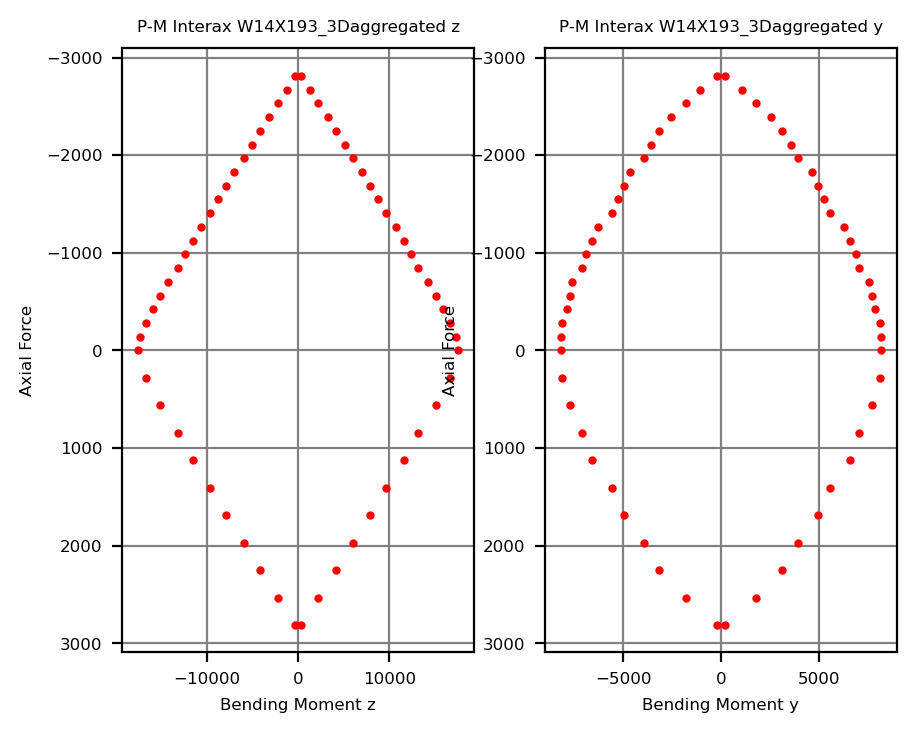

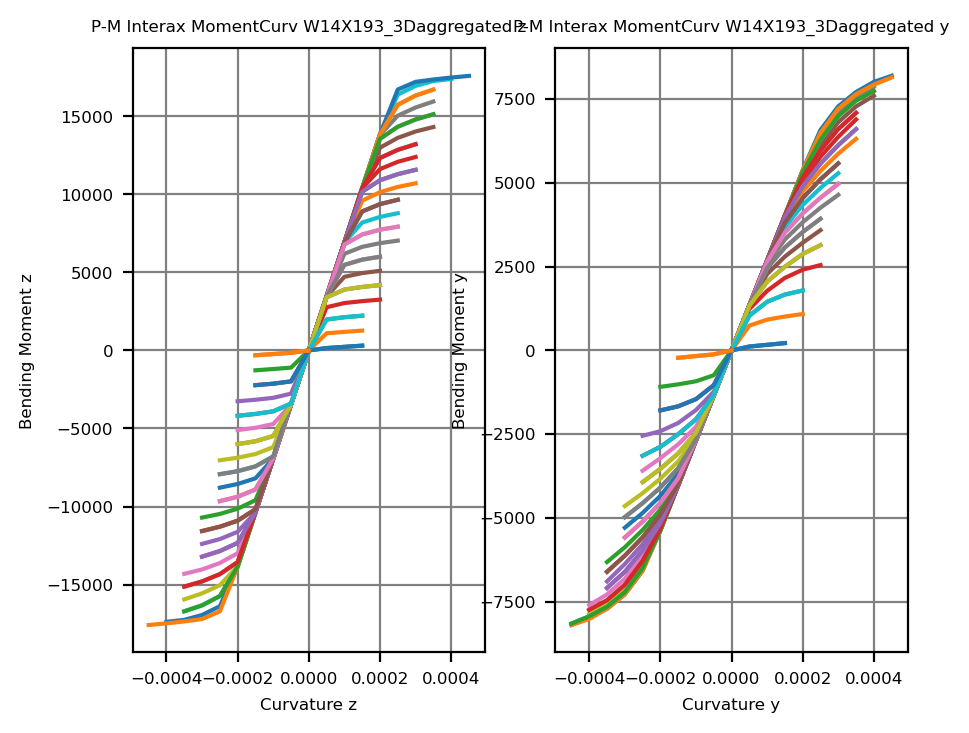

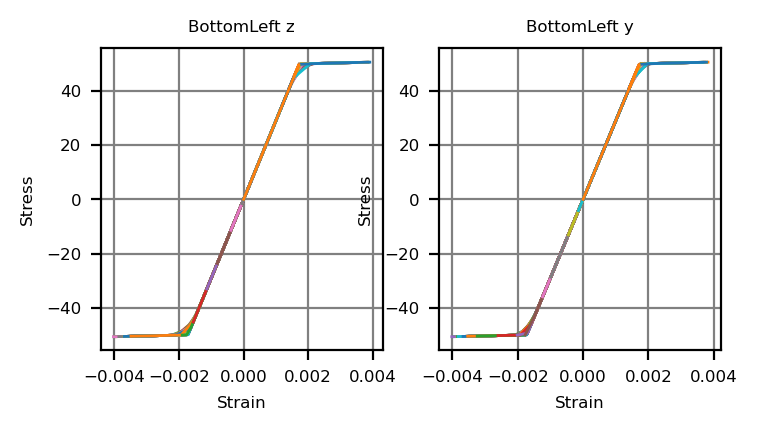

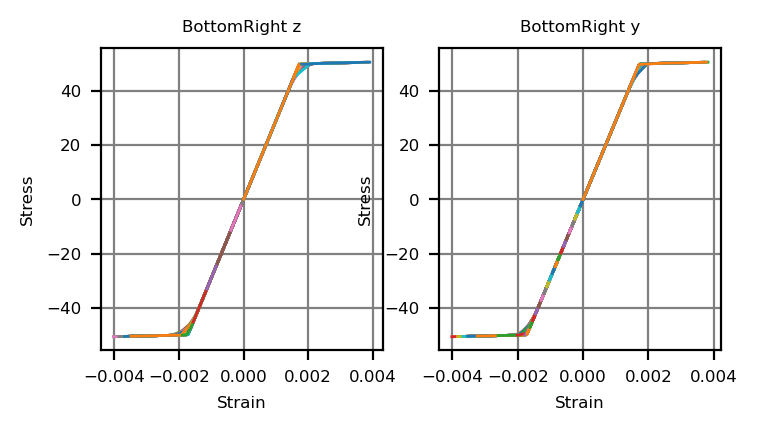

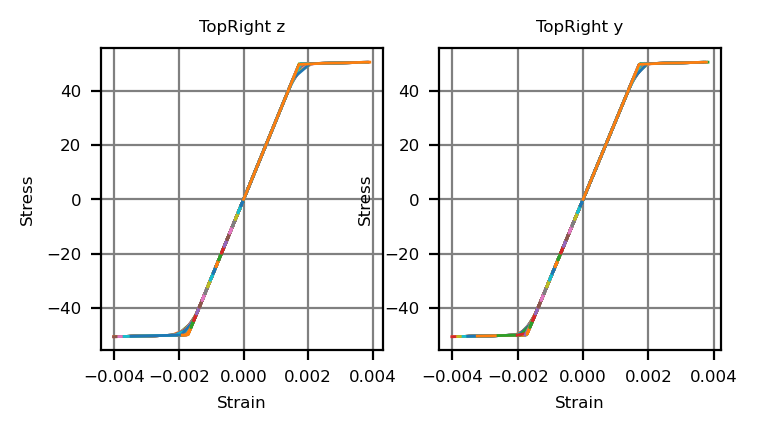

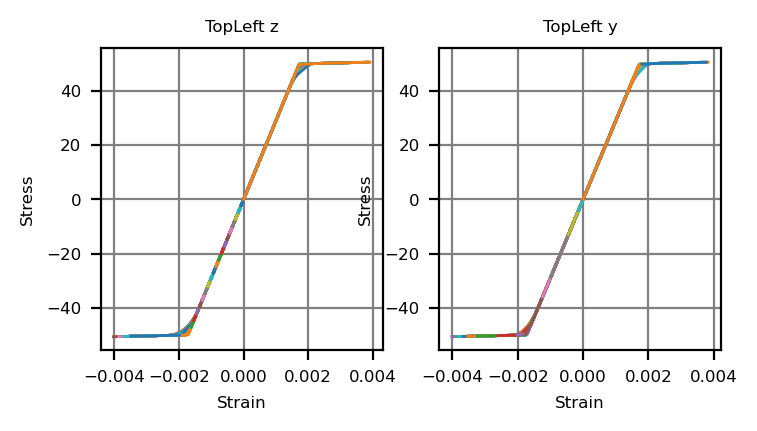

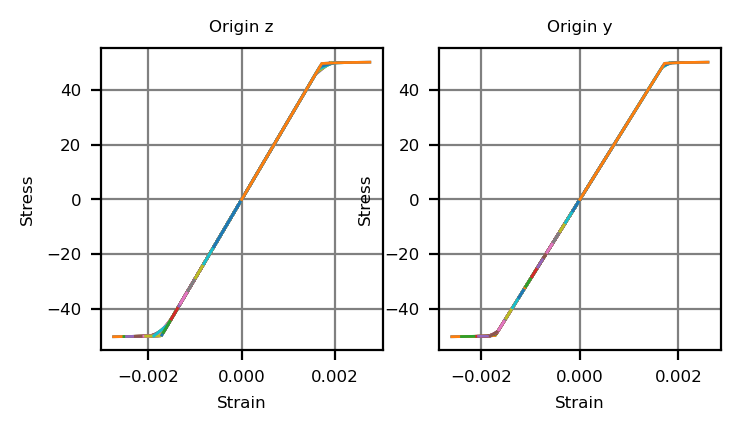

In [17]:
# Plot P-M Interaction Data
FiberFig = {}
FiberAx = {}
thisFigPMI = plt.figure('P-M Interax ' + testSectionLabel,figsize=(5,4), dpi=200, facecolor='w', edgecolor='k' )
thisFigMomCurv = plt.figure('Moment Curvature ' + testSectionLabel,figsize=(5,4), dpi=200, facecolor='w', edgecolor='k' )
iAx = 0
for BendingDirection in ['z','y']:
    iAx += 1
    axPMI = thisFigPMI.add_subplot(1,2,iAx)
    axMomCurv = thisFigMomCurv.add_subplot(1,2,iAx)

    for CurvatureSign in PMinteraxData[testSectionLabel][BendingDirection].keys():
        for thisAxial in  PMinteraxData[testSectionLabel][BendingDirection][CurvatureSign].keys():
            thisMomCurvData = PMinteraxData[testSectionLabel][BendingDirection][CurvatureSign][thisAxial]
            #line, = axPMI.plot(thisMomCurvData['Moment'], thisMomCurvData['AxialForce'])
            axPMI.plot(max(thisMomCurvData['Moment'], key=abs), thisAxial,'ro',markersize = 2,linewidth = 1)
            line, = axMomCurv.plot(thisMomCurvData['Curvature'], thisMomCurvData['Moment'])
            StrainData = thisMomCurvData['StrainData'][SectionTagMap[testSectionLabel]]
            StressData = thisMomCurvData['StressData'][SectionTagMap[testSectionLabel]]
            for thisFiberLabel,thisFiberStrain in StrainData.items():
                if not thisFiberLabel in FiberFig.keys():
                    FiberFig[thisFiberLabel]= plt.figure('Fiber SS ' + testSectionLabel + thisFiberLabel,figsize=(4,2), dpi=200, facecolor='w', edgecolor='k' )
                if not thisFiberLabel+ ' ' + BendingDirection in FiberAx.keys():
                    FiberAx[thisFiberLabel+ ' ' + BendingDirection] = FiberFig[thisFiberLabel].add_subplot(1,2,iAx)
                thisFiberStress = StressData[thisFiberLabel]
                line, = FiberAx[thisFiberLabel+ ' ' + BendingDirection].plot(thisFiberStrain,thisFiberStress,linewidth = 1)
    formatAx(axPMI,'P-M Interax ' + testSectionLabel + ' ' + BendingDirection,'Bending Moment ' + BendingDirection,'Axial Force',6,6)
    formatAx(axMomCurv,'P-M Interax MomentCurv ' + testSectionLabel + ' ' + BendingDirection ,'Curvature ' + BendingDirection,'Bending Moment ' + BendingDirection,6,6)
    # reverse y axis
    ylims = axPMI.get_ylim()
    axPMI.set_ylim(ylims[1],ylims[0])
for thisAxLabel,thisValue in FiberAx.items():
    formatAx(thisValue,thisAxLabel,'Strain','Stress',6,6)
plt.show()            

In [18]:
# ELASTIC SECTIONs
# material properties:
Es  = 29000*ksi # Steel Young's Modulus
nu  = 0.3 # Poisson's ratio
Gs  = Es/2./(1+nu) # Torsional stiffness Modulus
J  = Ubig # set large torsional stiffness
# beam sections: W24x94
AgBeam  = 27.7*math.pow(inch,2) # cross-sectional area
IzBeam  = 2700.*math.pow(inch,4) # moment of Inertia
IyBeam  = 109.*math.pow(inch,4) # moment of Inertia
# girder sections: W24x94
AgGird  = 27.7*math.pow(inch,2) # cross-sectional area
IzGird  = 2700.*math.pow(inch,4) # moment of Inertia
IyGird  = 109.*math.pow(inch,4) # moment of Inertia

secTag += 1
SectionTagMap['ElasticBeam'] = secTag
ops.section('Elastic',secTag,Es,AgBeam,IzBeam,IyBeam,Gs,J)
secTag += 1
SectionTagMap['ElasticGirder'] = secTag
ops.section('Elastic',secTag,Es,AgGird,IzGird,IyGird,Gs,J)


In [19]:
# ------ frame configuration
NStory  = 12 # number of stories above ground level
NBay  = 4 # number of bays in X direction
NBayZ  = 5 # number of bays in Z direction
print(' "Number of Stories in Y: ' + str(NStory) + ' Number of bays in X: ' + str(NBay) + ' Number of bays in Z: ' + str(NBayZ) )
NFrame  = NBayZ+1 # actually deal with frames in Z direction, as this is an easy extension of the 2d model

# define GEOMETRY -------------------------------------------------------------
# define structure-geometry paramters
LCol  = 14*ft # column height (parallel to Y axis)
LBeam  = 24*ft # beam length (parallel to X axis)
LGird  = 24*ft # girder length (parallel to Z axis)

# define NODAL COORDINATES
Dlevel  = 10000 # numbering increment for new-level nodes
Dframe  = 100 # numbering increment for new-frame nodes
for frame in range(1,NFrame+1,1):
	Z  = (frame-1)*LGird
	for level in range(1,NStory+1+1,1):
		Y  = (level-1)*LCol
		for pier in range(1,NBay+1+1,1):
			X  = (pier-1)*LBeam
			nodeID  = frame*Dframe+level*Dlevel+pier
			ops.node(nodeID,X,Y,Z)     #  actually define node
		# endCurlyBrace 
	# endCurlyBrace 
# endCurlyBrace 

# rigid diaphragm nodes
RigidDiaphragm  = 'ON'  # options: ON, OFF. specify this before the analysis parameters are set the constraints are handled differently.
Xa  = (NBay*LBeam)/2 # mid-span coordinate for rigid diaphragm
Za  = (NFrame-1)*LGird/2
iMasterNode  = []
for level in range(2,NStory+1+1,1):
	Y  = (level-1)*LCol
	# rigid-diaphragm nodes in center of each diaphram
	MasterNodeID  = 9900+level
	ops.node(MasterNodeID,Xa,Y,Za)     #  master nodes for rigid diaphragm
	ops.fix(MasterNodeID,0,1,0,1,0,1)     #  constrain other dofs that dont belong to rigid diaphragm control
	iMasterNode.append(MasterNodeID)
	perpDirn  = 2 # perpendicular to plane of rigid diaphragm
	for frame in range(1,NFrame+1,1):
		for pier in range(1,NBay+1+1,1):
			nodeID  = level*Dlevel+frame*Dframe+pier
			ops.rigidDiaphragm(perpDirn,MasterNodeID,nodeID)     #  define Rigid Diaphram,
		# endCurlyBrace 
	# endCurlyBrace 
# endCurlyBrace 

# determine support nodes where ground motions are input, for multiple-support excitation
iSupportNode  = []
for frame in range(1,NFrame+1,1):
	level  = 1
	for pier in range(1,NBay+1+1,1):
		nodeID  = level*Dlevel+frame*Dframe+pier
		iSupportNode.append(nodeID)
	# endCurlyBrace 
# endCurlyBrace 

# BOUNDARY CONDITIONS
ops.fixY(0.0,1,1,1,0,1,0)     #  pin all Y=0.0 nodes

 "Number of Stories in Y: 12 Number of bays in X: 4 Number of bays in Z: 5


In [20]:
# calculated MODEL PARAMETERS, particular to this model
# Set up parameters that are particular to the model for displacement control
IDctrlNode  = int(((NStory+1)*Dlevel+NFrame*Dframe)+1) # node where displacement is read for displacement control
IDctrlDOF  = 1  # degree of freedom of displacement read for displacement control
LBuilding  = NStory*LCol # total building height

# Define SECTIONS -------------------------------------------------------------
SectionType  = 'FiberSection'  # options: Elastic FiberSection

# define section tags:
ColSecTag  = SectionTagMap['W14X193_3Daggregated']
BeamSecTag  = SectionTagMap['ElasticBeam']
GirdSecTag  = SectionTagMap['ElasticGirder']


In [21]:
# define ELEMENTS
# set up geometric transformations of element
# separate columns and beams, in case of P-Delta analysis for columns
IDColTransf  = 1 # all columns
IDBeamTransf  = 2 # all beams
IDGirdTransf  = 3 # all girds
ColTransfType  = 'Linear'  # options for columns: Linear PDelta Corotational
ops.geomTransf(ColTransfType,IDColTransf,0,0,1)     #  orientation of column stiffness affects bidirectional response.
ops.geomTransf('Linear',IDBeamTransf,0,0,1)
ops.geomTransf('Linear',IDGirdTransf,1,0,0)

# Define Beam-Column Elements
numIntgrPts  = 5 # number of Gauss integration points for nonlinear curvature distribution
# columns
N0col  = 10000-1 # column element numbers
level  = 0
for frame in range(1,NFrame+1,1):
	for level in range(1,NStory+1,1):
		for pier in range(1,NBay+1+1,1):
			elemID  = N0col +level*Dlevel+frame*Dframe+pier
			nodeI  = level*Dlevel+frame*Dframe+pier
			nodeJ  = (level+1)*Dlevel+frame*Dframe+pier
			ops.element('nonlinearBeamColumn',elemID,nodeI,nodeJ,numIntgrPts,ColSecTag,IDColTransf)     #  columns
		# endCurlyBrace 
	# endCurlyBrace 
# endCurlyBrace 

# beams -- parallel to X-axis
N0beam  = 1000000 # beam element numbers
for frame in range(1,NFrame+1,1):
	for level in range(2,NStory+1+1,1):
		for bay in range(1,NBay+1,1):
			elemID  = N0beam+level*Dlevel+frame*Dframe+bay
			nodeI  = level*Dlevel+frame*Dframe+bay
			nodeJ  = level*Dlevel+frame*Dframe+bay+1
			ops.element('nonlinearBeamColumn',elemID,nodeI,nodeJ,numIntgrPts,BeamSecTag,IDBeamTransf)     #  beams
		# endCurlyBrace 
	# endCurlyBrace 
# endCurlyBrace 

# girders -- parallel to Z-axis
N0gird  = 2000000 # gird element numbers
for frame in range(1,NFrame-1+1,1):
	for level in range(2,NStory+1+1,1):
		for bay in range(1,NBay+1+1,1):
			elemID  = N0gird+level*Dlevel+frame*Dframe+bay
			nodeI  = level*Dlevel+frame*Dframe+bay
			nodeJ  = level*Dlevel+(frame+1)*Dframe+bay
			ops.element('nonlinearBeamColumn',elemID,nodeI,nodeJ,numIntgrPts,GirdSecTag,IDGirdTransf)     #  Girds
		# endCurlyBrace 
	# endCurlyBrace 
# endCurlyBrace 

In [22]:
# Turn on interaction for plots so you can rotate 3D plots
%matplotlib notebook

<IPython.core.display.Javascript object>


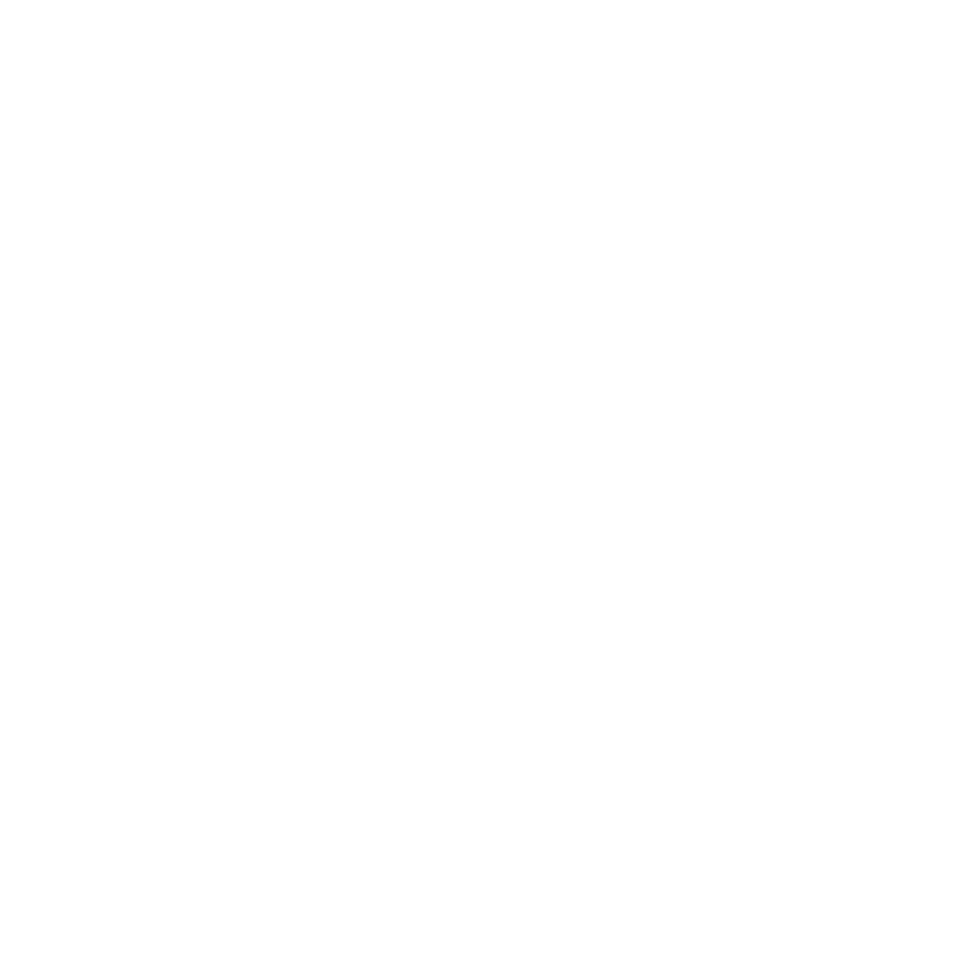

In [23]:
# DRAW MODEL
modelLineColor = 'blue'
modellinewidth = 1
Vert = 'Y'
# Set up fig
thisFig = plt.figure('Model',figsize=(4,4), dpi=200,facecolor='whitesmoke')
axModel = thisFig.add_subplot(1,1,1, projection='3d',facecolor='whitesmoke')

elementList = ops.getEleTags()
for thisEleTag in elementList:
    eleNodesList = ops.eleNodes(thisEleTag)
    if len(eleNodesList)==2:
        [NodeItag,NodeJtag] = eleNodesList
        NodeCoordListI=ops.nodeCoord(NodeItag)
        NodeCoordListJ=ops.nodeCoord(NodeJtag)
        [NodeIxcoord,NodeIycoord,NodeIzcoord]=NodeCoordListI
        [NodeJxcoord,NodeJycoord,NodeJzcoord]=NodeCoordListJ
        if Vert=='Y':
            axModel.plot([NodeIzcoord,NodeJzcoord],[NodeIxcoord,NodeJxcoord],[NodeIycoord,NodeJycoord],modelLineColor,linewidth = modellinewidth)
        else: # vertical = Z, the default
            axModel.plot([NodeIxcoord,NodeJxcoord],[NodeIycoord,NodeJycoord],[NodeIzcoord,NodeJzcoord],modelLineColor,linewidth = modellinewidth)

if Vert=='Y':            
    formatAx(axModel,'Model','Z','X',6,4)
    axModel.set_zlabel("Y", fontsize=4)            
else:
    formatAx(axModel,'Model','X','Y',6,4)
    axModel.set_zlabel("Z", fontsize=4)            
axModel.tick_params('z', labelsize=4)
    
set_aspect_equal_3d(axModel)


In [24]:
# Deformation Standar Mode Shapes
#  With the following eigen command OpenSees will compute the standard eigenvalues and eigenvectors
#  For this case you do not need do define masses in the model.
#   therefore, the eigenvalues do not correspond to any physical frequencies
Nmodes = NStory
lam = ops.eigen('-standard','-symmBandLapack',Nmodes)

<IPython.core.display.Javascript object>


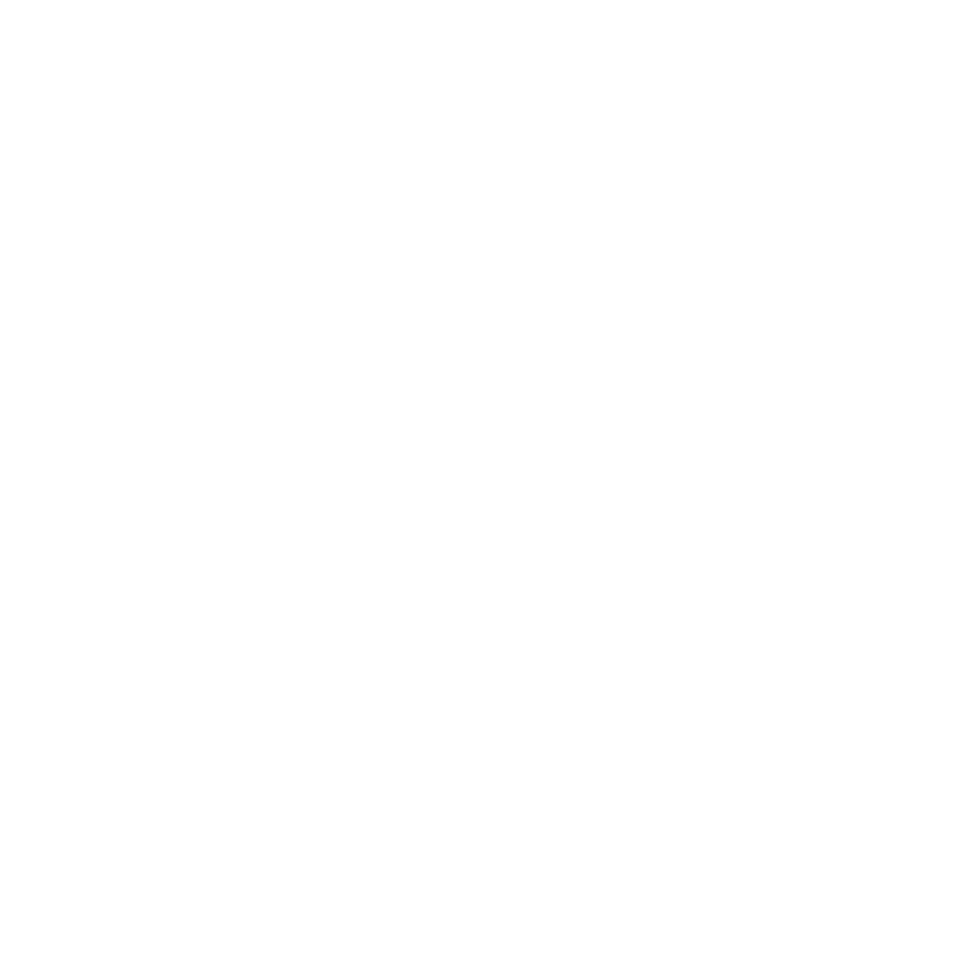

<IPython.core.display.Javascript object>


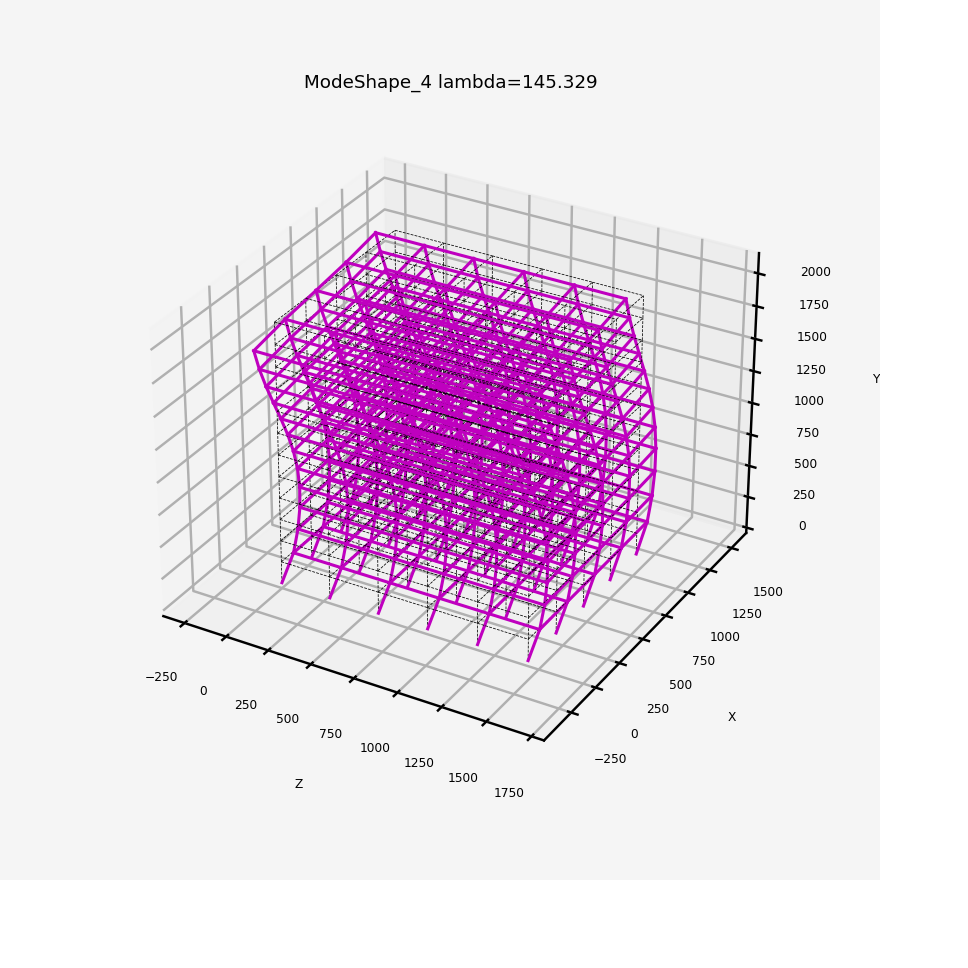

<IPython.core.display.Javascript object>


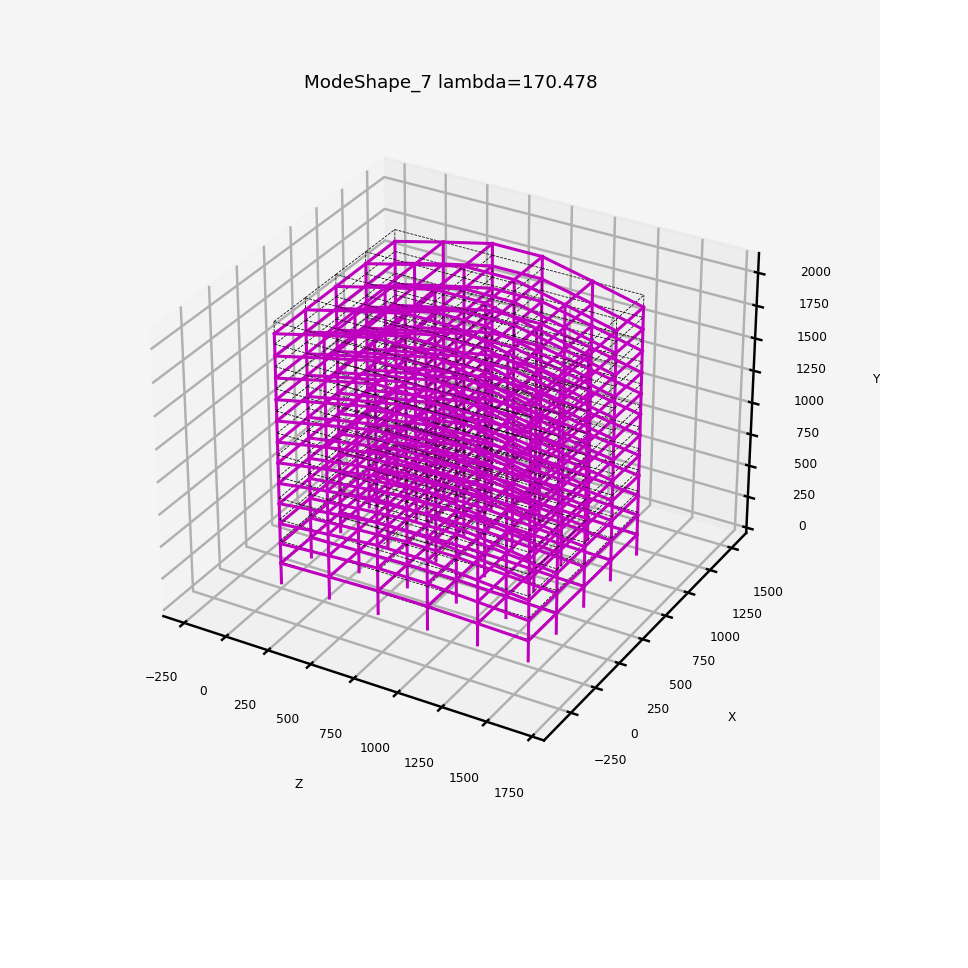

<IPython.core.display.Javascript object>


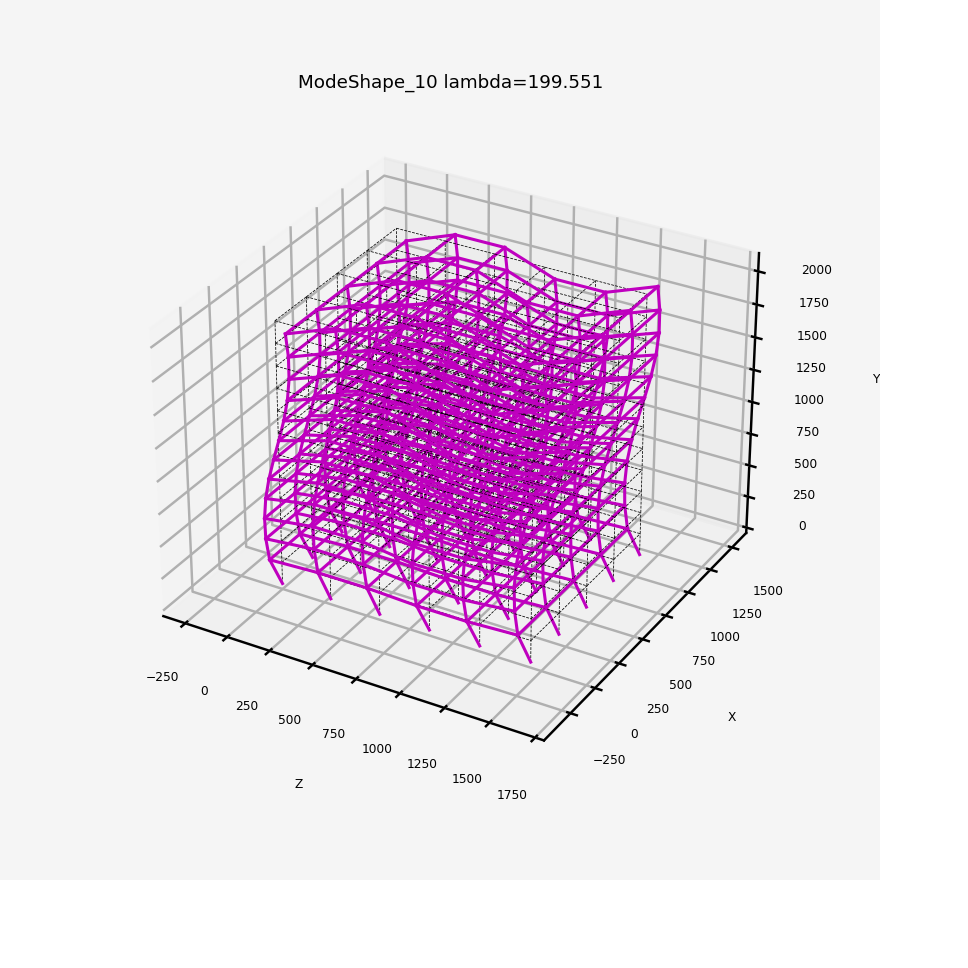

In [25]:
# Draw Eigenvectors
# (put this in a new cell so you can re-run this without having to recompute the eigenvalues)
ModeAmp = 1000
modelLineColor = 'k--'
modellinewidth = 0.25
modeLineColor = 'm'
modelinewidth = 1.0
DrawModelSwitch = True
Vert = 'Y'
Nplots = 4
modeIncr = int(Nmodes/Nplots)
for iMode in range(0,Nmodes,modeIncr):
    thisMode = iMode+1
    NodeEigen = {}
    for thisNodeTag in ops.getNodeTags():
        thisEigenVector = ops.nodeEigenvector(thisNodeTag,abs(thisMode))
        NodeEigen[thisNodeTag] = thisEigenVector

    thisTitle = 'ModeShape_' + str(thisMode) + ' lambda=' + str(round(lam[iMode],3))
    # Set up fig
    thisFig = plt.figure(thisTitle,figsize=(4,4), dpi=200,facecolor='whitesmoke')
    axModel = thisFig.add_subplot(1,1,1, projection='3d',facecolor='whitesmoke')

    elementList = ops.getEleTags()
    for thisEleTag in elementList:
        eleNodesList = ops.eleNodes(thisEleTag)
        if len(eleNodesList)==2:
            [NodeItag,NodeJtag] = eleNodesList
            NodeCoordListI=ops.nodeCoord(NodeItag)
            NodeCoordListJ=ops.nodeCoord(NodeJtag)
            [NodeIxcoord,NodeIycoord,NodeIzcoord]=NodeCoordListI
            [NodeJxcoord,NodeJycoord,NodeJzcoord]=NodeCoordListJ
            if DrawModelSwitch:
                if Vert=='Y':
                    axModel.plot([NodeIzcoord,NodeJzcoord],[NodeIxcoord,NodeJxcoord],[NodeIycoord,NodeJycoord],modelLineColor,linewidth = modellinewidth)
                else: # vertical = Z, the default
                    axModel.plot([NodeIxcoord,NodeJxcoord],[NodeIycoord,NodeJycoord],[NodeIzcoord,NodeJzcoord],modelLineColor,linewidth = modellinewidth)
            # draw eigenVector
            [NodeIxcoordEigen,NodeIycoordEigen,NodeIzcoordEigen]=[NodeIxcoord+NodeEigen[NodeItag][0]*ModeAmp,NodeIycoord+NodeEigen[NodeItag][1]*ModeAmp,NodeIzcoord+NodeEigen[NodeItag][2]*ModeAmp]
            [NodeJxcoordEigen,NodeJycoordEigen,NodeJzcoordEigen]=[NodeJxcoord+NodeEigen[NodeJtag][0]*ModeAmp,NodeJycoord+NodeEigen[NodeJtag][1]*ModeAmp,NodeJzcoord+NodeEigen[NodeJtag][2]*ModeAmp]
            if Vert=='Y':
                thisLine, = axModel.plot([NodeIzcoordEigen,NodeJzcoordEigen],[NodeIxcoordEigen,NodeJxcoordEigen],[NodeIycoordEigen,NodeJycoordEigen],modeLineColor,linewidth = modelinewidth)
            else: # vertical = Z, the default
                thisLine, = axModel.plot([NodeIxcoordEigen,NodeJxcoordEigen],[NodeIycoordEigen,NodeJycoordEigen],[NodeIzcoordEigen,NodeJzcoordEigen],modeLineColor,linewidth = modelinewidth)

    if Vert=='Y':            
        formatAx(axModel,thisTitle,'Z','X',6,4)
        axModel.set_zlabel("Y", fontsize=4)            
    else:
        formatAx(axModel,thisTitle,'X','Y',6,4)
        axModel.set_zlabel("Z", fontsize=4)            
    axModel.tick_params('z', labelsize=4)
    set_aspect_equal_3d(axModel)
    

In [26]:
#This Code has been developed by Silvia Mazzoni. Please acknowledge this in your scripts, when applicable